In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

In [84]:
import math
import torch_scatter

class MLP(torch.nn.Module):
    """Multi-Layer perceptron"""
    def __init__(self, input_size, hidden_size, output_size, layers, layernorm=True):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(layers):
            self.layers.append(torch.nn.Linear(
                input_size if i == 0 else hidden_size,
                output_size if i == layers - 1 else hidden_size,
            ))
            if i != layers - 1:
                self.layers.append(torch.nn.ReLU())
        if layernorm:
            self.layers.append(torch.nn.LayerNorm(output_size))
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            if isinstance(layer, torch.nn.Linear):
                layer.weight.data.normal_(0, 1 / math.sqrt(layer.in_features))
                layer.bias.data.fill_(0)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


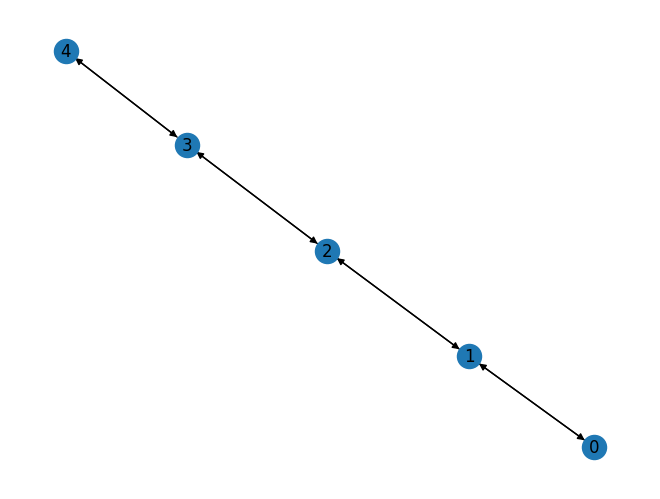

tensor([[1.0000, 5.0192],
        [1.0000, 1.8816],
        [1.0000, 2.5652],
        [1.0000, 2.2054],
        [1.0000, 6.3108],
        [1.0000, 1.1268],
        [1.0000, 0.2496],
        [1.0000, 6.0805]])


In [134]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph

def create_gnn_graph(coordinates, E_initial, metadata):
    """
    Create a graph data object for a GNN model.

    Args:
    - coordinates (list of tuples): A list of 2D coordinates for each node.
    - E_initial (float): The initial value for the edge attribute.

    Returns:
    - data (Data): A PyG Data object representing the graph.
    """

    # Convert coordinates to tensor
    node_features = torch.tensor(coordinates, dtype=torch.float)
    
    # Add the load as a node attribute
    load = torch.rand(node_features.size(0), 1)
    dist_boundary = torch.norm(node_features - torch.tensor([[0, 0]], dtype=torch.float), dim=1).unsqueeze(1)   
    
    # Create edges
    num_nodes = len(coordinates)
    edge_index = radius_graph(node_features, r=metadata["radius"], loop=False)
    
    # Calculate edge attributes (e.g., Euclidean distance)
    distance = torch.norm(node_features[edge_index[0]] - node_features[edge_index[1]], dim=1).unsqueeze(1)
    # Ensure E_edge is a 2-dimensional tensor by unsqueezing
    # Convert E_initial to a PyTorch tensor
    E_initial = torch.tensor(E_initial, dtype=torch.float)
    # Correctly generate a tensor with random values uniformly distributed between 0 and 1, then scale by E_initial
    E_edge = torch.rand(edge_index.size(1), 1) * E_initial

    # Now, both tensors have shape [number_of_edges, 1] and can be concatenated
    edge_attr = torch.cat([distance, E_edge], dim=1)
    
    # Create a graph data object
    data = Data(pos=node_features, edge_index=edge_index, edge_attr=edge_attr, node_attr=load)
    
    return data

# Example usage
metadata = {"radius": 1.1}
coordinates = [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0)]
E_initial = np.random.rand(1) * 10
graph_data = create_gnn_graph(coordinates, E_initial, metadata)

graph = to_networkx(graph_data)
nx.draw(graph, with_labels=True)
plt.show()

print(graph_data.edge_attr)

In [90]:
class InteractionNetwork(MessagePassing):
    """Interaction Network as proposed in this paper:
    https://proceedings.neurips.cc/paper/2016/hash/3147da8ab4a0437c15ef51a5cc7f2dc4-Abstract.html"""
    def __init__(self, hidden_size, layers):
        super().__init__()
        self.lin_edge = MLP(hidden_size, hidden_size, hidden_size, layers)
        self.lin_node = MLP(hidden_size, hidden_size, hidden_size, layers)

    def forward(self, x, edge_index, edge_feature):
        edge_out, aggr = self.propagate(edge_index, x=(x, x), edge_feature=edge_feature)
        node_out = self.lin_node(torch.cat((x, aggr), dim=-1))
        edge_out = edge_feature + edge_out
        node_out = x + node_out
        return node_out, edge_out

    def message(self, x_i, x_j, edge_feature):
        x = torch.cat((x_i, x_j, edge_feature), dim=-1)
        print(x.shape)
        x = self.lin_edge(x)
        return x

    def aggregate(self, inputs, index, dim_size=None):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce="sum")
        return (inputs, out)

In [106]:
class LearnedSimulator(torch.nn.Module):
    """Graph Network-based Simulators(GNS)"""
    def __init__(
        self,
        hidden_size=128,
        n_mp_layers=10,  # number of GNN layers
        node_feature_dim=2,  # Adjusted to match graph_data node features
        edge_feature_dim=2,  # Adjusted to match graph_data edge features
        output_dim=2,  # Adjusted to match desired output dimension
    ):
        super().__init__()
        self.node_in = MLP(node_feature_dim, hidden_size, hidden_size, 3)
        self.edge_in = MLP(edge_feature_dim, hidden_size, hidden_size, 3)
        self.node_out = MLP(hidden_size, hidden_size, output_dim, 3, layernorm=False)
        self.n_mp_layers = n_mp_layers
        self.layers = torch.nn.ModuleList([InteractionNetwork(
            hidden_size, 3
        ) for _ in range(n_mp_layers)])

    def forward(self, data):
        # pre-processing
        # node feature: just data.x
        node_feature = self.node_in(data.x)
        edge_feature = self.edge_in(data.edge_attr)
        # stack of GNN layers
        for i in range(self.n_mp_layers):
            node_feature, edge_feature = self.layers[i](node_feature, data.edge_index, edge_feature=edge_feature)
        # post-processing
        out = self.node_out(node_feature)
        return out

In [118]:
node_in = MLP(2, 128, 128, 3)
print(graph_data.x.shape)
print(node_in(graph_data.x).shape)

torch.Size([5, 2])
torch.Size([5, 128])


In [127]:
edge_in = MLP(2, 128, 128, 3)
edge_in(graph_data.edge_attr).shape

torch.Size([8, 128])

In [129]:
n_mp_layers = 1
layers = torch.nn.ModuleList([InteractionNetwork(
            hidden_size, 3
        ) for _ in range(n_mp_layers)])

ModuleList(
  (0): InteractionNetwork()
)